# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime
from functools import reduce

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Churn Analysis") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [38]:
# load dataset
sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

#### Clean dataset

In [6]:
print((df.count(), len(df.columns)))

(286500, 18)


In [7]:
df.toPandas().isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

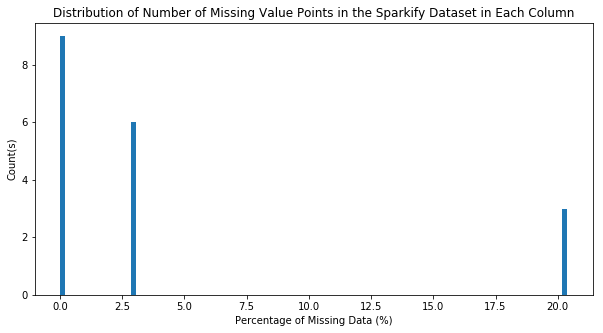

In [8]:
null_number = df.toPandas().isnull().sum()

plt.figure(figsize=(10, 5))
plt.title('Distribution of Number of Missing Value Points in the Sparkify Dataset in Each Column')
plt.hist(null_number / df.count() * 100, bins=100)
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Count(s)')
plt.show()

In [9]:
# Investigate patterns in the amount of missing data in each column
data_under_2 = (null_number / df.count() * 100) <= 2
data_over_2 = (null_number / df.count() * 100) > 2
attri_over_2 = null_number.loc[(null_number / df.count() * 100) > 2]
print("Attributes with equal to or under 2% of missing data: {}".format(data_under_2.sum()))
print("Attributes with over 2% of missing data: {}".format(data_over_2.sum()))
print("Attributes with missing data that exceeds 2%: \n{}".format(attri_over_2 / df.count() * 100))

Attributes with equal to or under 2% of missing data: 9
Attributes with over 2% of missing data: 9
Attributes with missing data that exceeds 2%: 
artist          20.381152
firstName        2.913089
gender           2.913089
lastName         2.913089
length          20.381152
location         2.913089
registration     2.913089
song            20.381152
userAgent        2.913089
dtype: float64


In [39]:
# Remove the outlier columns from the dataset
df = df.drop(*['artist', 'firstname', 'gender', 'lastname', 'length', 'location', 'registration', 'song', 'userAgent'])
df.show()

+---------+-------------+-----+------+---------------+---------+------+-------------+------+
|     auth|itemInSession|level|method|           page|sessionId|status|           ts|userId|
+---------+-------------+-----+------+---------------+---------+------+-------------+------+
|Logged In|           50| paid|   PUT|       NextSong|       29|   200|1538352117000|    30|
|Logged In|           79| free|   PUT|       NextSong|        8|   200|1538352180000|     9|
|Logged In|           51| paid|   PUT|       NextSong|       29|   200|1538352394000|    30|
|Logged In|           80| free|   PUT|       NextSong|        8|   200|1538352416000|     9|
|Logged In|           52| paid|   PUT|       NextSong|       29|   200|1538352676000|    30|
|Logged In|           81| free|   PUT|       NextSong|        8|   200|1538352678000|     9|
|Logged In|           82| free|   PUT|       NextSong|        8|   200|1538352886000|     9|
|Logged In|           53| paid|   PUT|       NextSong|       29|   200

In [11]:
df.toPandas().isnull().sum()

auth             0
itemInSession    0
level            0
method           0
page             0
sessionId        0
status           0
ts               0
userId           0
dtype: int64

In [40]:
# filter out empty user ID from earlier dataset exploration
df = df.filter(df.userId != "")
df.count()

278154

In [13]:
# look at all the possible 'auth', 'level', and 'page' attributes 
df.select(["auth", "level", "page"]).dropDuplicates().sort("auth").show()

+---------+-----+--------------------+
|     auth|level|                page|
+---------+-----+--------------------+
|Cancelled| free|Cancellation Conf...|
|Cancelled| paid|Cancellation Conf...|
|Logged In| free|            Settings|
|Logged In| free|              Logout|
|Logged In| free|                Help|
|Logged In| paid|       Save Settings|
|Logged In| paid|               About|
|Logged In| free|         Thumbs Down|
|Logged In| paid|              Logout|
|Logged In| free|         Roll Advert|
|Logged In| free|           Thumbs Up|
|Logged In| paid|         Thumbs Down|
|Logged In| paid|                Home|
|Logged In| paid|           Thumbs Up|
|Logged In| paid|          Add Friend|
|Logged In| paid|    Submit Downgrade|
|Logged In| free|            NextSong|
|Logged In| paid|              Cancel|
|Logged In| free|               About|
|Logged In| free|      Submit Upgrade|
+---------+-----+--------------------+
only showing top 20 rows



In [14]:
# look at all the possible 'auth', 'gender', and 'ts' attributes
df.select(["auth", "page", "ts"]).dropDuplicates().sort("auth").show()

+---------+--------------------+-------------+
|     auth|                page|           ts|
+---------+--------------------+-------------+
|Cancelled|Cancellation Conf...|1539375441000|
|Cancelled|Cancellation Conf...|1542356278000|
|Cancelled|Cancellation Conf...|1540062068000|
|Cancelled|Cancellation Conf...|1539274781000|
|Cancelled|Cancellation Conf...|1540353577000|
|Cancelled|Cancellation Conf...|1539318918000|
|Cancelled|Cancellation Conf...|1539971825000|
|Cancelled|Cancellation Conf...|1539475237000|
|Cancelled|Cancellation Conf...|1541184816000|
|Cancelled|Cancellation Conf...|1542181031000|
|Cancelled|Cancellation Conf...|1543073753000|
|Cancelled|Cancellation Conf...|1540062847000|
|Cancelled|Cancellation Conf...|1538753070000|
|Cancelled|Cancellation Conf...|1538943990000|
|Cancelled|Cancellation Conf...|1541153274000|
|Cancelled|Cancellation Conf...|1543009344000|
|Cancelled|Cancellation Conf...|1541463632000|
|Cancelled|Cancellation Conf...|1541120964000|
|Cancelled|Ca

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Defining churn as people who cancelled Sparkify

In [15]:
df.select(["auth"]).dropDuplicates().sort("auth").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



#### Cells below are for exploring the data

In [116]:
# function for converting Row object to string
convert_row_to_string = lambda x, y: x.asDict()[y]

# function for plotting distribution
def plot(dfList, attr: str):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for i, (df, auth) in enumerate(zip(dfList, ['Churned Users', 'Stayed Users'])):
        plot = sns.countplot(x=attr, data=df, ax=ax[i])
        ax[i].set_title(auth)
        for p in plot.patches:
            plot.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', \
                          va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [117]:
page = df.select(["page"]).dropDuplicates().sort("page").collect()
pageList = list(map(convert_row_to_string, page, ['page' for i in range(len(page))]))
print("Unique user events: ", pageList)
print("# of unique pages: ", len(pageList))

Unique user events:  ['About', 'Add Friend', 'Add to Playlist', 'Cancel', 'Cancellation Confirmation', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']
# of unique pages:  19


In [19]:
users = df.select(["userId"]).dropDuplicates().sort("userId").collect()
usersList = list(map(convert_row_to_string, users, ['userId' for i in range(len(users))]))
print("# of unique users in Sparkify: %d" % len(usersList))

# of unique users in Sparkify: 225


In [20]:
# users who churned
churn_users = df.filter(df.auth == "Cancelled").groupby(df.userId).count().orderBy(df.userId).collect()
churn_users_list = list(map(convert_row_to_string, churn_users, ['userId' for i in range(len(churn_users))]))
print("Unique users who churned: ", churn_users_list)
print("# of unique users who churned: ", len(churn_users_list))

Unique users who churned:  ['100001', '100003', '100005', '100006', '100007', '100009', '100011', '100012', '100013', '100014', '100015', '100017', '100019', '100021', '100022', '100023', '100024', '100025', '101', '103', '105', '106', '12', '121', '122', '125', '129', '143', '17', '18', '200001', '200011', '200015', '200016', '200017', '200018', '200020', '200021', '200024', '28', '29', '3', '300001', '300007', '32', '51', '53', '54', '58', '70', '73', '87']
# of unique users who churned:  52


In [21]:
# users who stayed
users_who_stayed = [u for u in usersList if not u in churn_users_list]
print("Unique users who stayed: ", users_who_stayed)
print("# of unique users who stayed: ", len(users_who_stayed))

Unique users who stayed:  ['10', '100', '100002', '100004', '100008', '100010', '100016', '100018', '102', '104', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '123', '124', '126', '127', '128', '13', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '16', '19', '2', '20', '200002', '200003', '200004', '200005', '200006', '200007', '200008', '200009', '200010', '200012', '200014', '200019', '200022', '200023', '200025', '21', '22', '23', '24', '25', '26', '27', '30', '300002', '300003', '300004', '300005', '300006', '300008', '300009', '300010', '300011', '300012', '300013', '300014', '300015', '300016', '300017', '300018', '300019', '300020', '300021', '300022', '300023', '300024', '300025', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '49', '5

In [22]:
# dataframes of churned and stayed users for 'level' attribute
df_level_churn = df.filter(df.auth == 'Cancelled').select(['auth', 'level']).toPandas()
df_level_login = df.filter((df.auth == 'Logged In') & (col("userId").isin(users_who_stayed))).select(['auth', 'level']).toPandas()

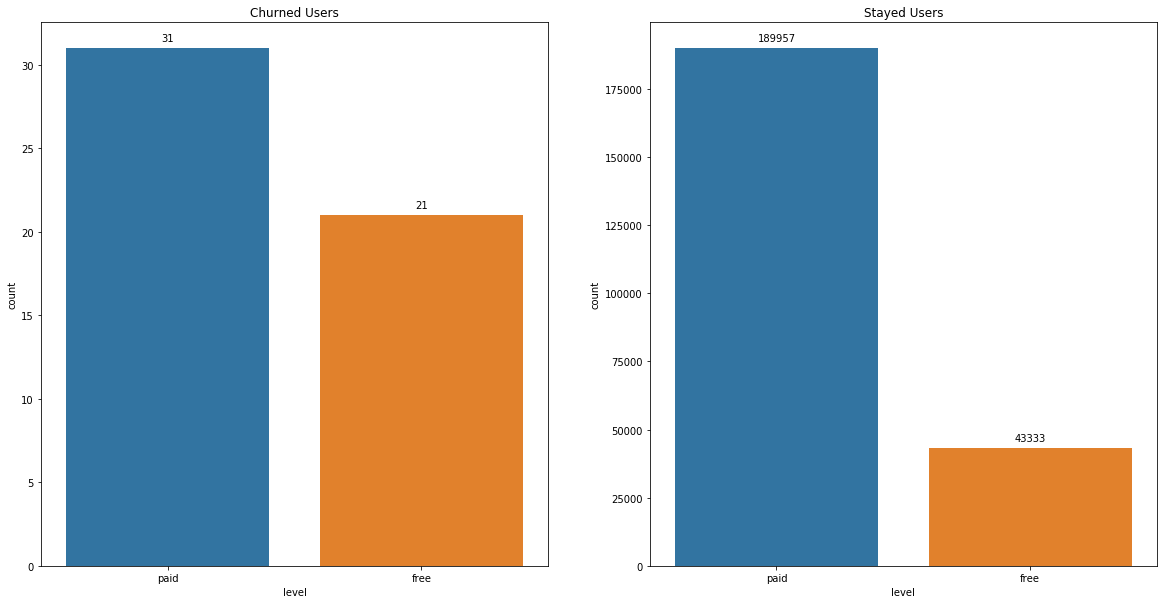

In [23]:
plot([df_level_churn, df_level_login], 'level')

**Note:** From the plot above, we can clearly see that paid users tend to cancel Sparkify. However, paid users also tend to stay with Sparkify, and so we would need to look at more attributes to see how churned and stayed users behave. 

In [41]:
# plot timestamp of for churn|d and stayed users

In [42]:
# convert epoch timestamps to readable timestamps
convert_time = udf(lambda x: datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", convert_time(df.ts))

In [43]:
df.select(["userId", "auth", "time", "level", "page"]).dropDuplicates().sort("auth").show()

+------+---------+-------------------+-----+--------------------+
|userId|     auth|               time|level|                page|
+------+---------+-------------------+-----+--------------------+
|    32|Cancelled|2018-10-08 21:10:46| paid|Cancellation Conf...|
|    53|Cancelled|2018-11-19 12:34:56| paid|Cancellation Conf...|
|     3|Cancelled|2018-10-30 04:59:03| paid|Cancellation Conf...|
|100013|Cancelled|2018-11-02 18:53:36| paid|Cancellation Conf...|
|    29|Cancelled|2018-11-14 07:37:11| paid|Cancellation Conf...|
|   105|Cancelled|2018-10-12 20:17:21| paid|Cancellation Conf...|
|100003|Cancelled|2018-10-11 16:19:41| free|Cancellation Conf...|
|200016|Cancelled|2018-11-16 08:17:58| free|Cancellation Conf...|
|200001|Cancelled|2018-10-15 18:55:20| free|Cancellation Conf...|
|100014|Cancelled|2018-11-20 19:04:09| paid|Cancellation Conf...|
|100021|Cancelled|2018-11-25 11:03:02| free|Cancellation Conf...|
|100012|Cancelled|2018-11-01 19:35:00| free|Cancellation Conf...|
|100006|Ca

In [44]:
# lambda functions for getting hour and weekday from 'time' attribute
get_hour = udf(lambda x: datetime.fromtimestamp(x/1000).hour)
get_weekday = udf(lambda x: datetime.fromtimestamp(x/1000).isoweekday())

In [45]:
df = df.withColumn("hour", get_hour(df.ts))
df = df.withColumn("weekday", get_weekday(df.ts))

In [46]:
df.select(["userId", "auth", "time", "hour", "weekday"]).dropDuplicates().sort("auth").show()

+------+---------+-------------------+----+-------+
|userId|     auth|               time|hour|weekday|
+------+---------+-------------------+----+-------+
|    28|Cancelled|2018-11-06 00:20:32|   0|      2|
|100014|Cancelled|2018-11-20 19:04:09|  19|      2|
|100023|Cancelled|2018-10-14 00:00:37|   0|      7|
|    73|Cancelled|2018-10-24 17:33:07|  17|      3|
|     3|Cancelled|2018-10-30 04:59:03|   4|      2|
|300007|Cancelled|2018-10-05 02:08:58|   2|      5|
|    87|Cancelled|2018-10-20 15:49:16|  15|      6|
|   143|Cancelled|2018-10-15 07:34:14|   7|      1|
|   129|Cancelled|2018-10-17 00:29:21|   0|      3|
|    12|Cancelled|2018-10-22 07:29:34|   7|      1|
|    53|Cancelled|2018-11-19 12:34:56|  12|      1|
|100019|Cancelled|2018-10-07 22:57:51|  22|      7|
|100017|Cancelled|2018-10-20 19:14:07|  19|      6|
|100012|Cancelled|2018-11-01 19:35:00|  19|      4|
|200016|Cancelled|2018-11-16 08:17:58|   8|      5|
|    18|Cancelled|2018-10-07 20:26:30|  20|      7|
|200017|Canc

In [30]:
# dataframes of churned and stayed users for 'hour' attribute
df_hour_churn = df.filter(df.auth == 'Cancelled').select(['auth', 'hour']).toPandas()
df_hour_login = df.filter((df.auth == 'Logged In') & (col("userId").isin(users_who_stayed))).select(['auth', 'hour']).toPandas()

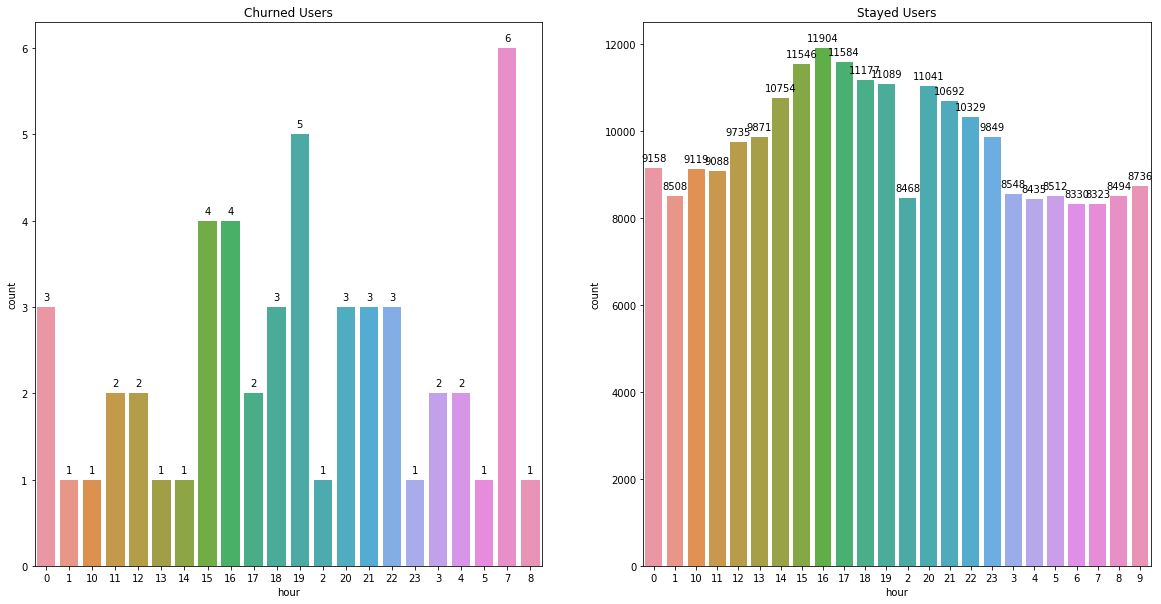

In [31]:
plot([df_hour_churn, df_hour_login], 'hour')

**Note:** We can see that churned users are most active in the morning at 7am and from 3-12pm, whereas the stayed users are somewhat active at night from 8-12pm but most active in the day from 10am-6pm. From the hour of the day, we can conclude that stayed users are more consistent with interacting with Sparkify throughout than churned users do.  

In [32]:
# dataframes of churned and stayed users for 'weekday' attribute
df_weekday_churn = df.filter(df.auth == 'Cancelled').select(['auth', 'weekday']).toPandas()
df_weekday_login = df.filter((df.auth == 'Logged In') & (col("userId").isin(users_who_stayed))).select(['auth', 'weekday']).toPandas()

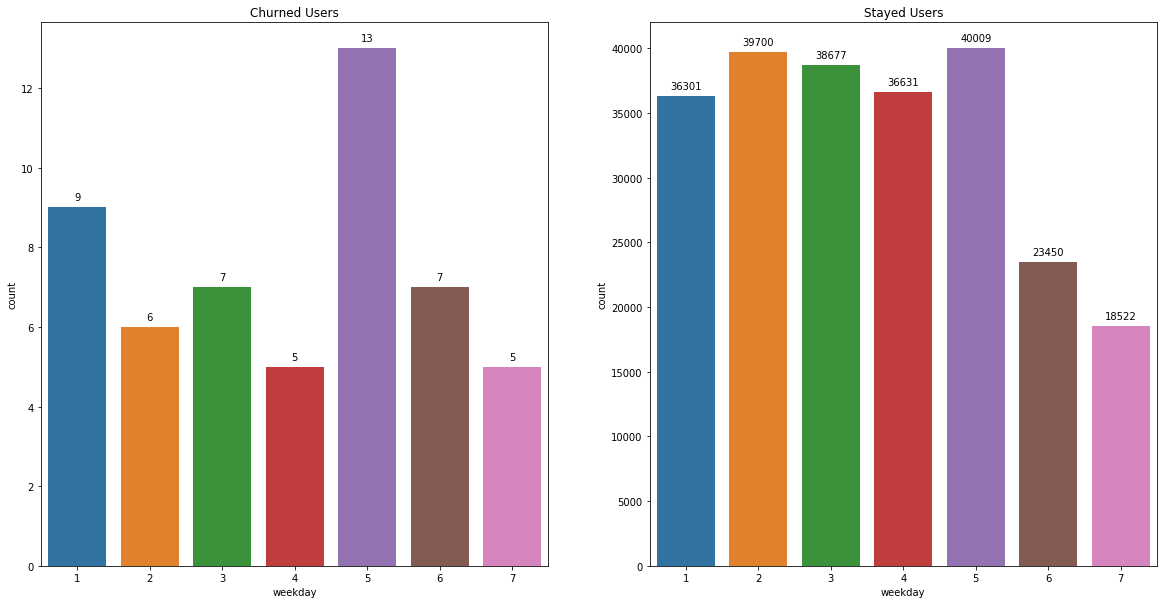

In [33]:
plot([df_weekday_churn, df_weekday_login], 'weekday')

**Note:** From the two plots above where 1-7 represents Monday-Sunday respectively, it is obvious that stayed users interact with Sparkify mostly on weekdays, whereas churned users interact with Sparkify mostly on Mondays and Fridays. We can also see how the sporadic the pattern is for churned users compared to stayed users.   

In [34]:
# function to find users' frequency per page
def get_user_counts_per_page(pages, users):
    usersPerPage = []
    start = time.time()
    for page in pages:
        usersCounts = df.filter((df.page == page) & (col("userId").isin(users))) \
            .select('userId') \
            .groupBy('userId') \
            .agg({'userId':'count'}) \
            .withColumnRenamed('count(userId)', 'count').collect()
        usersCountsList = list(map(convert_row_to_string, usersCounts, ['count' for i in range(len(usersCounts))]))
        usersPerPage.append(usersCountsList) if usersCountsList else usersPerPage.append([0])
    end = time.time()
    print("Total time elapsed for extracting churned users' visit count per page:", end-start, "s")
    return usersPerPage

# function to sort page list
def getKey(item):
    return item[1]

In [35]:
churnUserPageList = []
sum_of_page_per_churn_user = get_user_counts_per_page(pageList, churn_users_list)
sum_of_pages = list(map(lambda counts: reduce(lambda x,y: x+y, counts), sum_of_page_per_churn_user))

print("# of visits per page by each churned user:")
for i, (page, sumOfPage) in enumerate(zip(pageList, sum_of_pages)):
    churnUserPageList.append((page, sumOfPage))
    print("{0}: {1}".format(page, sumOfPage))

Total time elapsed for extracting churned users' visit count per page: 28.10676646232605 s
# of visits per page by each churned user:
About: 56
Add Friend: 636
Add to Playlist: 1038
Cancel: 52
Cancellation Confirmation: 52
Downgrade: 337
Error: 32
Help: 239
Home: 1672
Logout: 553
NextSong: 36394
Roll Advert: 967
Save Settings: 58
Settings: 270
Submit Downgrade: 9
Submit Upgrade: 32
Thumbs Down: 496
Thumbs Up: 1859
Upgrade: 112


In [36]:
# sort page list from in descending order for visit frequency
sum_of_pages.sort(reverse=True)
churnUserPageList = sorted(churnUserPageList, key=getKey, reverse=True)

sortedChurnUserPageList = []
for pair in churnUserPageList:
    sortedChurnUserPageList.append(pair[0])

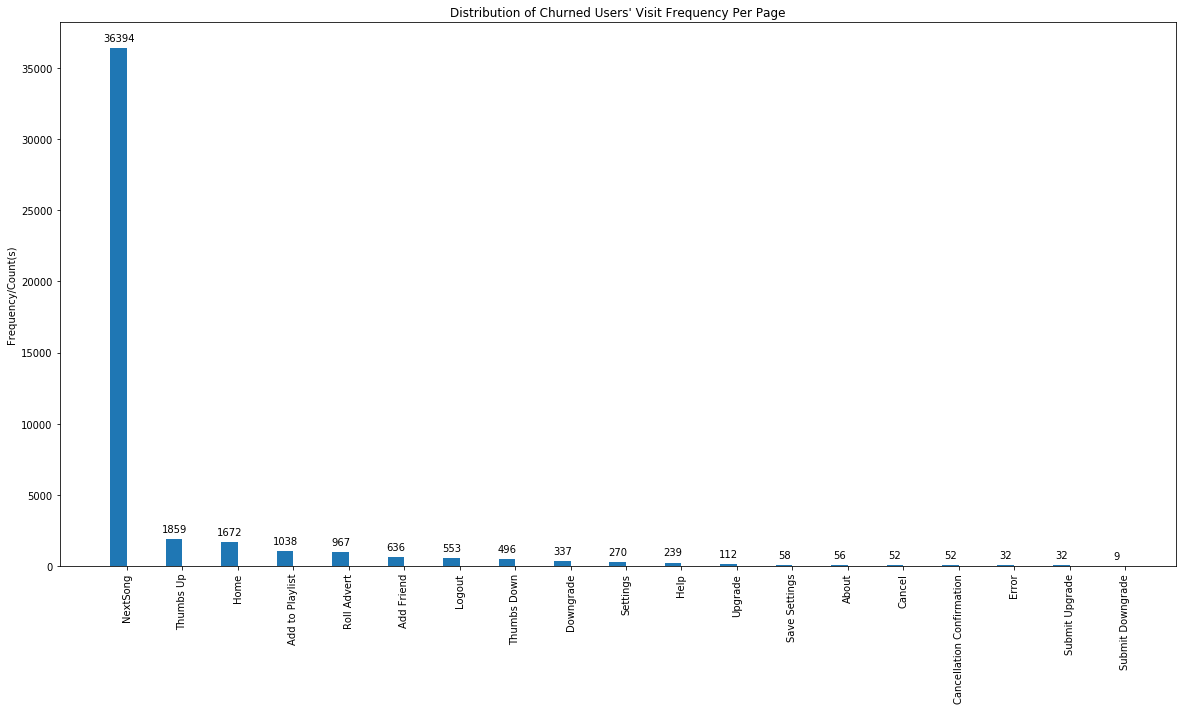

In [37]:
# Distribution of the frequency at which churned users visited each page
fig, ax = plt.subplots(figsize=(20, 10))
x = np.arange(len(sortedChurnUserPageList))
width = 0.3

bar = ax.bar(x - width/2, sum_of_pages, width)

ax.set_ylabel("Frequency/Count(s)")
ax.set_title("Distribution of Churned Users' Visit Frequency Per Page")
ax.set_xticks(x)
ax.set_xticklabels(sortedChurnUserPageList, rotation='vertical')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', \
                  va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.legend()

In [38]:
stayedUsersPageList = []
sum_of_page_per_stayed_user = get_user_counts_per_page(pageList, users_who_stayed)
sum_of_pages_stayed_users = list(map(lambda counts: reduce(lambda x,y: x+y, counts), sum_of_page_per_stayed_user))

print("# of visits per page by each stayed user:")
for i, (page, sumOfPage) in enumerate(zip(pageList, sum_of_pages_stayed_users)):
    stayedUsersPageList.append((page, sumOfPage))
    print("{0}: {1}".format(page, sumOfPage))

Total time elapsed for extracting churned users' visit count per page: 28.659865856170654 s
# of visits per page by each stayed user:
About: 439
Add Friend: 3641
Add to Playlist: 5488
Cancel: 0
Cancellation Confirmation: 0
Downgrade: 1718
Error: 220
Help: 1215
Home: 8410
Logout: 2673
NextSong: 191714
Roll Advert: 2966
Save Settings: 252
Settings: 1244
Submit Downgrade: 54
Submit Upgrade: 127
Thumbs Down: 2050
Thumbs Up: 10692
Upgrade: 387


In [41]:
# sort page list from in descending order for visit frequency
sum_of_pages_stayed_users.sort(reverse=True)
stayedUsersPageList = sorted(stayedUsersPageList, key=getKey, reverse=True)

sortedPageListForStayedUsers = []
for pair in stayedUsersPageList:
    sortedPageListForStayedUsers.append(pair[0])

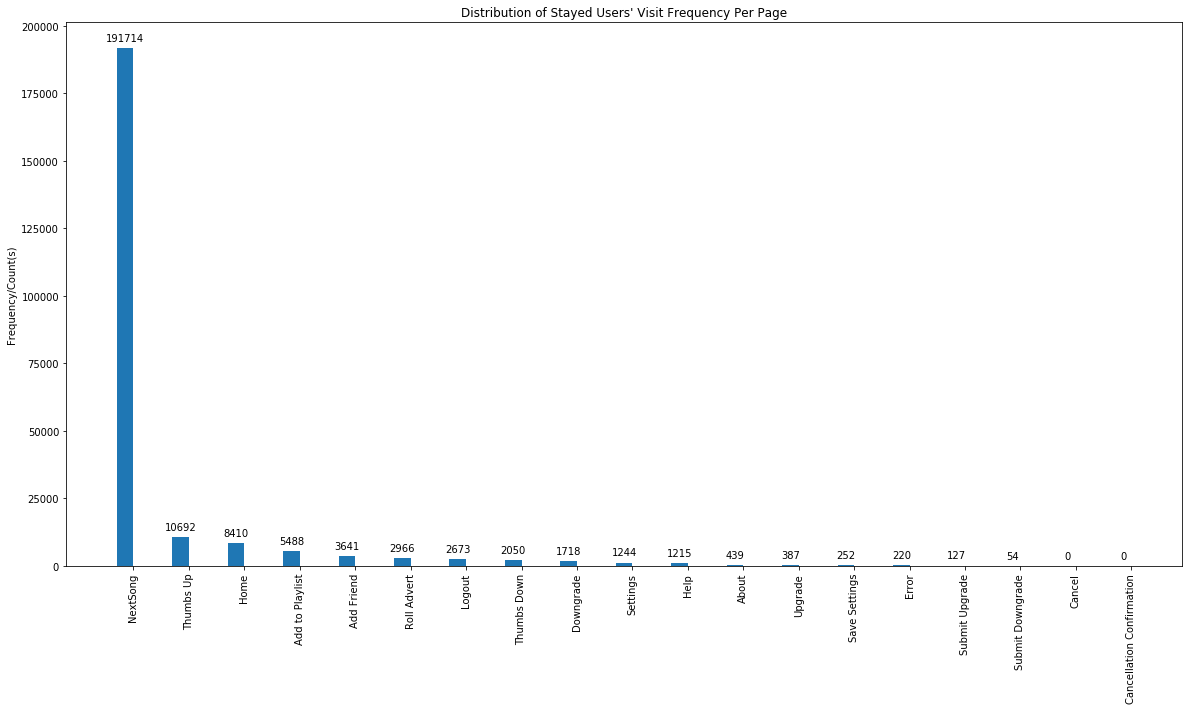

In [42]:
# Distribution of the frequency at which churned users visited each page
fig, ax = plt.subplots(figsize=(20, 10))
x = np.arange(len(sortedPageListForStayedUsers))
width = 0.3

bar = ax.bar(x - width/2, sum_of_pages_stayed_users, width)

ax.set_ylabel("Frequency/Count(s)")
ax.set_title("Distribution of Stayed Users' Visit Frequency Per Page")
ax.set_xticks(x)
ax.set_xticklabels(sortedPageListForStayedUsers, rotation='vertical')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', \
                  va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.legend()

In [43]:
# total event visit counts of churned and stayed users
totalCountsOfChurnUsers = reduce(lambda x, y: x+y, sum_of_pages)
totalCountsOfStayedUsers = reduce(lambda x, y: x+y, sum_of_pages_stayed_users)

In [44]:
# calculate how many counts of 'Downgrade' and 'Thumbs Down' events of stayed and cancelled users, which are usually  
# indicators of unsatisified users, are in the total number of stayed and cancelled users 
churnDowngrade = dict(churnUserPageList)['Downgrade'] / totalCountsOfChurnUsers
stayedDowngrade = dict(stayedUsersPageList)['Downgrade'] / totalCountsOfStayedUsers
churnThumbsDown = dict(churnUserPageList)['Thumbs Down'] / totalCountsOfChurnUsers
stayedThumbsDown = dict(stayedUsersPageList)['Thumbs Down'] / totalCountsOfStayedUsers

print("Relative proportion of 'Downgrade' in churned users group: ", churnDowngrade)
print("Relative proportion of 'Downgrade' in stayed users group: ", stayedDowngrade)
print("Relative proportion of 'Thumbs Down' in churned users group: ", churnThumbsDown)
print("Relative proportion of 'Thumbs Down' in stayed users group: ", stayedThumbsDown)

Relative proportion of 'Downgrade' in churned users group:  0.007511590584878745
Relative proportion of 'Downgrade' in stayed users group:  0.007364224784602855
Relative proportion of 'Thumbs Down' in churned users group:  0.011055634807417974
Relative proportion of 'Thumbs Down' in stayed users group:  0.008787346221441126


In [45]:
# how many counts of 'Add Friend', 'Upgrade', 'Add to Playlist', and 'Thumbs Up' events of stayed and cancelled users, which 
# are indicators of how well users interact with the service, are in the total number of stayed and cancelled users 
churnAddF = dict(churnUserPageList)['Add Friend'] / totalCountsOfChurnUsers
stayedAddF = dict(stayedUsersPageList)['Add Friend'] / totalCountsOfStayedUsers
churnUpgrade = dict(churnUserPageList)['Upgrade'] / totalCountsOfChurnUsers
stayedUpgrade = dict(stayedUsersPageList)['Upgrade'] / totalCountsOfStayedUsers
churnAddP = dict(churnUserPageList)['Add to Playlist'] / totalCountsOfChurnUsers
stayedAddP = dict(stayedUsersPageList)['Add to Playlist'] / totalCountsOfStayedUsers
churnThumbsUp = dict(churnUserPageList)['Thumbs Up'] / totalCountsOfChurnUsers
stayedThumbsUp = dict(stayedUsersPageList)['Thumbs Up'] / totalCountsOfStayedUsers

print("Relative proportion of 'Add Friend' in churned users group: ", churnAddF)
print("Relative proportion of 'Add Friend' in stayed users group: ", stayedAddF)
print("Relative proportion of 'Upgrade' in churned users group: ", churnUpgrade)
print("Relative proportion of 'Upgrade' in stayed users group: ", stayedUpgrade)
print("Relative proportion of 'Add to Playlist'' in churned users group: ", churnAddP)
print("Relative proportion of 'Add to Playlist' in stayed users group: ", stayedAddP)
print("Relative proportion of 'Thumbs Up' in churned users group: ", churnThumbsUp)
print("Relative proportion of 'Thumbs Up' in stayed users group: ", stayedThumbsUp)

Relative proportion of 'Add Friend' in churned users group:  0.014176176890156919
Relative proportion of 'Add Friend' in stayed users group:  0.015607184191349823
Relative proportion of 'Upgrade' in churned users group:  0.0024964336661911554
Relative proportion of 'Upgrade' in stayed users group:  0.0016588795061940075
Relative proportion of 'Add to Playlist'' in churned users group:  0.023136590584878745
Relative proportion of 'Add to Playlist' in stayed users group:  0.023524368811350678
Relative proportion of 'Thumbs Up' in churned users group:  0.04143634094151213
Relative proportion of 'Thumbs Up' in stayed users group:  0.04583136868275537


**Note:** From the bar graphs analyzing the user behaviors between users who stayed and cancelled, users who stayed and cancelled both like to explore different kinds of songs with their frequent interaction with the "NextSong" and "Home" events. However, when we look at indicators that show the potential unsatisfaction from the users about the service, we can see how cancelled users tend to downgrade and commit a 'Thumbs Down' event more frequently than stayed users do, as calculated in the cells above. Also, I used events, such as 'Add Friend', 'Upgrade', 'Add to Playlist', and 'Thumbs Up', as indicators about how well the users interact with the service, and the results calculated above show that stayed users commit 'Add Friend', 'Add to Playlist', and 'Thumbs Up' events more frequently than cancelled users, except for 'Upgrade'. I believe that even though cancelled users upgrade their service more, but were unsatisfied with the service which led to their eventual cancellation of the service.       

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [47]:
df.show()

+---------+-------------+-----+------+---------------+---------+------+-------------+------+-------------------+----+-------+
|     auth|itemInSession|level|method|           page|sessionId|status|           ts|userId|               time|hour|weekday|
+---------+-------------+-----+------+---------------+---------+------+-------------+------+-------------------+----+-------+
|Logged In|           50| paid|   PUT|       NextSong|       29|   200|1538352117000|    30|2018-10-01 00:01:57|   0|      1|
|Logged In|           79| free|   PUT|       NextSong|        8|   200|1538352180000|     9|2018-10-01 00:03:00|   0|      1|
|Logged In|           51| paid|   PUT|       NextSong|       29|   200|1538352394000|    30|2018-10-01 00:06:34|   0|      1|
|Logged In|           80| free|   PUT|       NextSong|        8|   200|1538352416000|     9|2018-10-01 00:06:56|   0|      1|
|Logged In|           52| paid|   PUT|       NextSong|       29|   200|1538352676000|    30|2018-10-01 00:11:16|   0| 

In [88]:
# Remove the attributes not considered for classification
df_processed = df.drop(*['method', 'sessionId', 'ts', 'status'])
df_processed.show()

+---------+-------------+-----+---------------+------+-------------------+----+-------+
|     auth|itemInSession|level|           page|userId|               time|hour|weekday|
+---------+-------------+-----+---------------+------+-------------------+----+-------+
|Logged In|           50| paid|       NextSong|    30|2018-10-01 00:01:57|   0|      1|
|Logged In|           79| free|       NextSong|     9|2018-10-01 00:03:00|   0|      1|
|Logged In|           51| paid|       NextSong|    30|2018-10-01 00:06:34|   0|      1|
|Logged In|           80| free|       NextSong|     9|2018-10-01 00:06:56|   0|      1|
|Logged In|           52| paid|       NextSong|    30|2018-10-01 00:11:16|   0|      1|
|Logged In|           81| free|       NextSong|     9|2018-10-01 00:11:18|   0|      1|
|Logged In|           82| free|       NextSong|     9|2018-10-01 00:14:46|   0|      1|
|Logged In|           53| paid|       NextSong|    30|2018-10-01 00:14:59|   0|      1|
|Logged In|           54| paid|A

#### Define features

In [89]:
# convert string to float
df_processed = df_processed.withColumn("hour", col("hour").cast("float"))
df_processed = df_processed.withColumn("weekday", col("weekday").cast("float"))

In [90]:
# defining label based on people who churned
indexer_label = StringIndexer(inputCol="auth", outputCol="Churn")
df_processed = indexer_label.fit(df_processed).transform(df_processed)

In [91]:
# create a new column as binary value for 'level' 
indexer_level = StringIndexer(inputCol="level", outputCol="levelBinary")
df_processed = indexer_level.fit(df_processed).transform(df_processed)

In [92]:
# create a new column as multiclass value for 'page' 
indexer_page = StringIndexer(inputCol="page", outputCol="pageMulti")
df_processed = indexer_page.fit(df_processed).transform(df_processed)

In [93]:
# combine all features by using VecotrAssembler
features = ["hour", "weekday", "levelBinary", "pageMulti"]
assembler = VectorAssembler(inputCols=features, outputCol="ChurnFeatures")
df_processed = assembler.transform(df_processed)

In [94]:
# scale features with Normalizer scaler
scaler = Normalizer(inputCol="ChurnFeatures", outputCol="NormedChurnFeatures")
df_processed = scaler.transform(df_processed)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [101]:
data = df_processed.select(col("Churn").alias("label"), col("NormedChurnFeatures").alias("features"))
data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|       (4,[1],[1.0])|
|  0.0|[0.0,0.7071067811...|
|  0.0|       (4,[1],[1.0])|
|  0.0|[0.0,0.7071067811...|
|  0.0|       (4,[1],[1.0])|
|  0.0|[0.0,0.7071067811...|
|  0.0|[0.0,0.7071067811...|
|  0.0|       (4,[1],[1.0])|
|  0.0|[0.0,0.3162277660...|
|  0.0|       (4,[1],[1.0])|
|  0.0|[0.0,0.7071067811...|
|  0.0|[0.0,0.1924500897...|
|  0.0|       (4,[1],[1.0])|
|  0.0|[0.0,0.7071067811...|
|  0.0|[0.0,0.5773502691...|
|  0.0|       (4,[1],[1.0])|
|  0.0|[0.0,0.7071067811...|
|  0.0|[0.0,0.7071067811...|
|  0.0|       (4,[1],[1.0])|
|  0.0|[0.0,0.7071067811...|
+-----+--------------------+
only showing top 20 rows



In [102]:
train, test = data.randomSplit([0.9, 0.1], seed=42)

In [104]:
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [105]:
# fitting training data to pipeline
model = lr.fit(train)
 
results = model.transform(test)

In [106]:
resultsRight = results.filter(results.label == results.prediction).count()
resultsCount = results.count()
print("Accuracy = %f" % (resultsRight/resultsCount))

Accuracy = 0.999783


In [108]:
results.select(["label", "prediction"]).dropDuplicates().sort("label").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  1.0|       0.0|
+-----+----------+



In [61]:
results.select().show()

27697

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.